In [55]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [56]:
df=pd.read_csv('product c.csv', parse_dates=['Month-Year'])

In [57]:
sales_c= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [58]:
sales_c.shape

(60, 2)

In [59]:
sales_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [60]:
sales_c['Sales'].sum()

45599092

In [61]:
sales_c = sales_c.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_c.head()

,ds,y
0,2019-01-01,496334
1,2019-02-01,306455
2,2019-03-01,476270
3,2019-04-01,628463
4,2019-05-01,366750


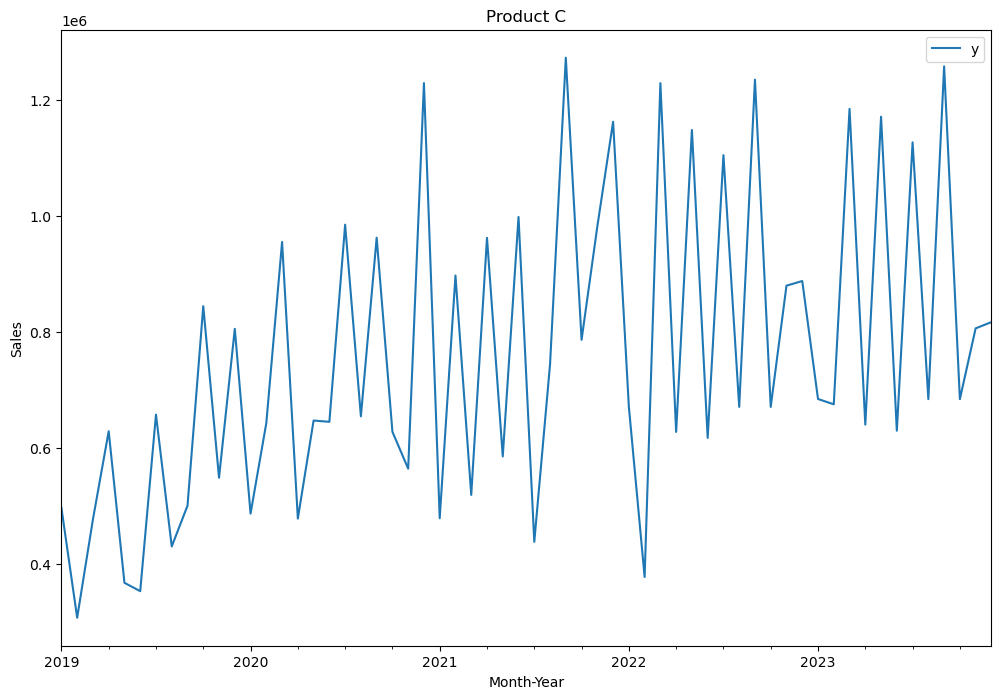

In [62]:
ax = sales_c.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product C')
plt.show()

In [63]:
from statsmodels.tsa.stattools import adfuller

In [64]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [65]:
adf_test(sales_c['y'])

ADF Statistics: -2.8900034461607835
p- value: 0.04652287109563067
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [66]:
train= sales_c[:48]
test=sales_c[48:]

# Hyperparameter Tuning

In [67]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1, 0.1008, 0.2006, 0.3004, 0.4002, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 2.008, 4.006, 6.004, 8.002, 10.0]

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:55:35 - cmdstanpy - INFO - Chain [1] start processing
15:55:35 - cmdstanpy - INFO - Chain [1] done processing
15:55:38 - cmdstanpy - INFO - Chain [1] start processing
15:55:38 - cmdstanpy - INFO - Chain [1] done processing
15:55:40 - cmdstanpy - INFO - Chain [1] start processing
15:55:40 - cmdstanpy - INFO - Chain [1] done processing
15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:45 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing
15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing
15:55:50 - cmdstanpy - INFO - Chain [1] start processing
15:55:50 - cmdstanpy - INFO - Chain [1] done processing
15:55:52 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
15:55:58 - cmdstanpy - INFO - Chain [1] start processing
15:55:58 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                     0.001                    0.010  341162.359979
1                     0.001                    0.100  306984.827195
2                     0.001                    1.000  345231.344043
3                     0.001                    2.008  324949.925643
4                     0.001                    4.006  324953.460931
..                      ...                      ...            ...
59                    0.500                    2.008  314530.662392
60                    0.500                    4.006  315450.093929
61                    0.500                    6.004  314201.543051
62                    0.500                    8.002  315482.190512
63                    0.500                   10.000  314317.433599

[64 rows x 3 columns]


In [68]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,rmse
17,0.1000,0.100,306386.354275
1,0.0010,0.100,306984.827195
25,0.1008,0.100,307142.267041
57,0.5000,0.100,307262.440075
49,0.4002,0.100,307315.107163
...,...,...,...
21,0.1000,6.004,325335.856925
39,0.2006,10.000,325460.142096
6,0.0010,8.002,325705.369171
0,0.0010,0.010,341162.359979


In [69]:
# Create a Prophet model
model = Prophet(changepoint_prior_scale=0.1000, seasonality_prior_scale=0.100, interval_width=0.95)

In [70]:
model.fit(train)

16:06:57 - cmdstanpy - INFO - Chain [1] start processing
16:06:58 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [72]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [73]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [74]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,7.901947e+05,438617.596046,1.158026e+06
49,2023-02-01,8.151415e+05,460453.948695,1.188179e+06
50,2023-03-01,1.044079e+06,685097.394971,1.382819e+06
51,2023-04-01,9.288241e+05,535064.781005,1.298049e+06
52,2023-05-01,9.412238e+05,585315.050984,1.314669e+06
53,2023-06-01,9.066149e+05,519162.981305,1.260710e+06
54,2023-07-01,1.045073e+06,671284.966527,1.421084e+06
55,2023-08-01,8.818582e+05,527200.296542,1.240316e+06
56,2023-09-01,1.229615e+06,866865.716023,1.597165e+06
57,2023-10-01,9.838538e+05,635884.258503,1.345585e+06


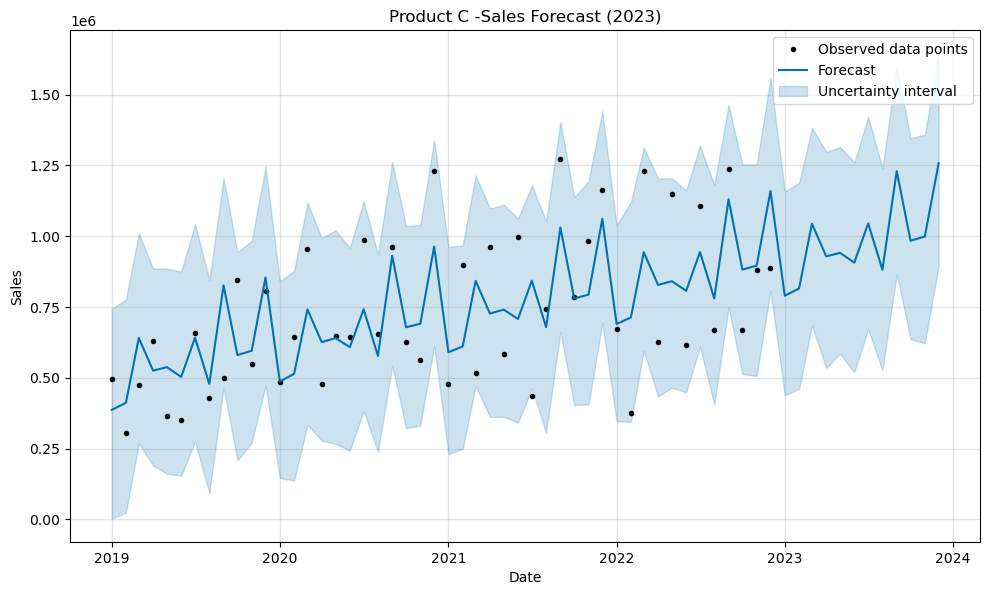

In [75]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product C -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

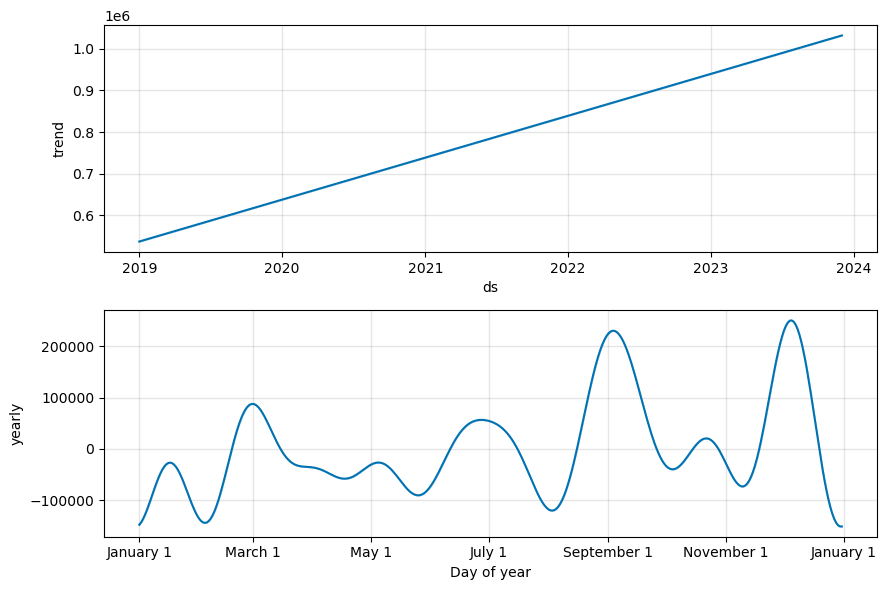

In [76]:
fig2 = model.plot_components(forecast)

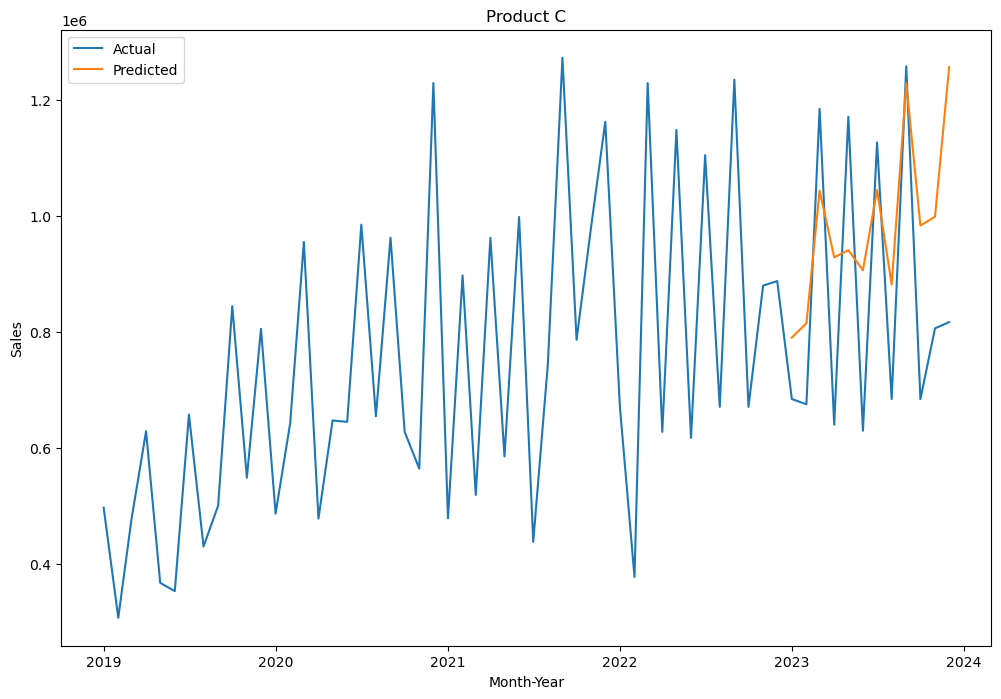

In [77]:
# Reset index of sales_b DataFrame
sales_c_reset_index = sales_c.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_c_reset_index['ds'], sales_c_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product C')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [78]:
#model evaluation

In [79]:
pred=forecasted_df['yhat']
test_df=test['y']

In [80]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 202195.573
MAPE - FB PROPHET: 0.264
MSE - FB PROPHET: 52674793894.369
RMSE - FB PROPHET: 229509.899


In [81]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [82]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [83]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.133751e+10,106477.729372,106477.729372,0.158742,0.158742,0.147069,1.0
1,62 days,2.760881e+11,525440.846623,525440.846623,1.394515,1.394515,0.821629,0.0
2,90 days,8.663913e+10,294345.255488,294345.255488,0.239376,0.239376,0.271921,1.0
3,121 days,1.220490e+11,349355.173951,349355.173951,0.556852,0.556852,0.435576,0.0
4,151 days,1.031455e+11,321162.776642,321162.776642,0.279567,0.279567,0.324997,0.0
5,182 days,1.130841e+11,336279.854026,336279.854026,0.544972,0.544972,0.428273,0.0
6,212 days,1.580762e+10,125728.354623,125728.354623,0.113750,0.113750,0.120609,1.0
7,243 days,5.260182e+10,229350.858317,229350.858317,0.342047,0.342047,0.292092,1.0
8,274 days,2.615744e+09,51144.340216,51144.340216,0.041388,0.041388,0.042262,1.0
9,304 days,1.327137e+11,364298.878735,364298.878735,0.543305,0.543305,0.427243,0.0


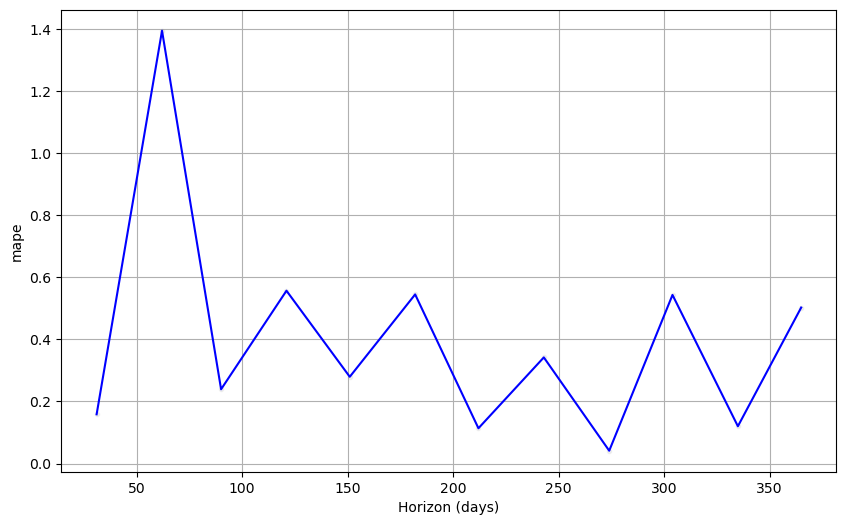

In [84]:
fig = plot_cross_validation_metric(df_cv, metric='mape')